In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh, lobpcg
import plotly.figure_factory as ff
import plotly.express as px
import os
import sys
import torch

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0   1191      0 --:--:-- --:--:-- --:--:--  1204
100  404k    0  404k    0     0  1222k      0 --:--:-- --:--:-- --:--:-- 1222k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-mdz1278r
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-mdz1278r
  Running command git checkout -q 9585a58d10cb2efcd159b058fa4af914203c1d0d
     |████████████████████████████████| 49 kB 2.0 MB/s 
     |████████████████████████████████| 596 kB 10.4 MB/s 


In [2]:
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

sys.path.append(os.path.abspath(''))

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-12-12 23:54:02--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1606 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-12-12 23:54:02 (30.9 MB/s) - ‘plot_image_grid.py’ saved [1606/1606]



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

DATA_DIR = 'drive/My Drive/shape retrieval/'

In [6]:
def convert_vertices(verts, faces):
  verts_ = verts.numpy()
  faces_ = faces[0].numpy()
  faces_ = np.sort(faces_, axis=1)
  return verts_, faces_

In [7]:
def area_of_faces(points, faces):
  area = np.zeros(len(faces))
  points = np.array(points)
  
  for i, triangle in enumerate(faces):
    a = np.linalg.norm(points[triangle[0]] - points[triangle[1]])
    b = np.linalg.norm(points[triangle[1]] - points[triangle[2]])
    c = np.linalg.norm(points[triangle[2]] - points[triangle[0]])
    s = (a+b+c) / 2.0
    
    
    area[i] = np.sqrt(s*(s-a)*(s-b)*(s-c))
    
  return area



In [22]:
def computeAB(verts, faces):
  n = verts.shape[0]

  row = []
  col = []
  M = []
  S = []

  for triangle in faces:
    v1 = triangle[0]
    v2 = triangle[1]
    v3 = triangle[2]

    a = np.linalg.norm(np.array(verts[v1]) - np.array(verts[v3]))
    b = np.linalg.norm(np.array(verts[v2]) - np.array(verts[v3]))
    c = np.linalg.norm(np.array(verts[v1]) - np.array(verts[v2]))

    area = 0.25 * np.sqrt((a + b + c) * (-a + b + c) * (a - b + c) * (a + b - c))

    row.append(v1)
    col.append(v2)
    row.append(v2)
    col.append(v1)

    M.append((a**2 + b**2 - c**2)/(8.* area))
    M.append((a**2 + b**2 - c**2)/(8.* area))

    S.append(area/12)
    S.append(area/12)

    row.append(v1)
    col.append(v3)
    row.append(v3)
    col.append(v1)

    M.append((b**2 + c**2 - a**2)/(8.* area))
    M.append((b**2 + c**2 - a**2)/(8.* area))

    S.append(area/12)
    S.append(area/12)

    row.append(v2)
    col.append(v3)
    row.append(v3)
    col.append(v2)

    M.append((a**2 + c**2 - b**2)/(8.* area))
    M.append((a**2 + c**2 - b**2)/(8.* area))

    S.append(area/12)
    S.append(area/12)

  M = csr_matrix((M, (row, col)), shape=(n, n), dtype=float).toarray()
  S = csr_matrix((S, (row, col)), shape=(n, n), dtype=float).toarray()

  sumM = np.sum(M, axis=1)
  sumM = np.diag(sumM)
  sumS = np.sum(S, axis=1)
  sumS = np.diag(sumS)

  M = -M + sumM
  S = S + sumS

  return M, S


def area_normalize(points, faces, spectrum):
    """
    Normalize a spectrum using areas as suggested in Reuter et al. (2006)
    Parameters
    ----------
    points : list of lists of 3 floats
        x,y,z coordinates for each vertex of the structure
    faces : list of lists of 3 integers
        3 indices to vertices that form a triangle on the mesh
    spectrum : list of floats
        LB spectrum of a given shape defined by _points_ and _faces_
    Returns
    -------
    new_spectrum : list of floats
        LB spectrum normalized by area
    """
    area = area_of_faces(points, faces)
    total_area = sum(area)

    new_spectrum = [x*total_area for x in spectrum]

    return new_spectrum


def index_normalize(spectrum):
    """
    Normalize a spectrum by division of index to account for linear increase of
    Eigenvalue magnitude (Weyl's law in 2D) as suggested in Reuter et al. (2006)
    and used in BrainPrint (Wachinger et al. 2015)
    Parameters
    ----------
    spectrum : list of floats
        LB spectrum of a given shape
    Returns
    -------
    new_spectrum : list of floats
        Linearly re-weighted LB spectrum
    """

    # define index list of floats
    idx = [float(i) for i in range(1,len(spectrum) + 1)]
    # if first entry is zero, shift index
    if (abs(spectrum[0]<1e-09)):
        idx = [i-1 for i in idx]
        idx[0] = 1.0
    # divide each element by its index
    new_spectrum = [x/i for x, i in zip(spectrum, idx)]

    return new_spectrum



def fem_laplacian(points, faces, spectrum_size=10,
                  verbose=False):
    
    # ----------------------------------------------------------------
    # Compute A and B matrices (from Reuter et al., 2009):
    # ----------------------------------------------------------------
    A, B = computeAB(points, faces)
    if A.shape[0] <= spectrum_size:
        if verbose:
            print("The 3D shape has too few vertices ({0} <= {1}). Skip.".
                  format(A.shape[0], spectrum_size))
        return None

    try :

        # eigs is for nonsymmetric matrices while
        # eigsh is for real-symmetric or complex-Hermitian matrices:
        # Martin Reuter: "small sigma shift helps prevent numerical
        #   instabilities with zero eigenvalue"
        eigenvalues, eigenvectors = eigsh(A, k=spectrum_size, M=B,
                                          sigma=-0.01)
        spectrum = eigenvalues.tolist()

    # ----------------------------------------------------------------
    # Use the lobpcg eigensolver:
    # ----------------------------------------------------------------
    except RuntimeError:     
           
        if verbose:
            print("eigsh() failed. Now try lobpcg.")
            print("Warning: lobpcg can produce different results from "
                  "Reuter (2006) shapeDNA-tria software.")
        # Initial eigenvector values:
        init_eigenvecs = np.random.random((A.shape[0], spectrum_size))

        eigenvalues, eigenvectors = lobpcg(A, init_eigenvecs, B=B,
                                           largest=True, maxiter=40)
        # Extract the real parts:
        spectrum = [value.real for value in eigenvalues]
        spectrum.sort()

    # ----------------------------------------------------------------
    # Normalizing:
    # ----------------------------------------------------------------

    spectrum = index_normalize(spectrum)
    spectrum = area_normalize(points,faces,spectrum)
    
    return spectrum

In [32]:
# having the spectrum, we can find the distance between two of them and classify shapes
def distance_spectrum(spectrum_1, spectrum_2):
  return np.linalg.norm((spectrum_1- spectrum_2))

In [16]:
file_names = ['cat', 'lion', 'horse']

column_name = []
file_addr = []

for name in file_names:
  for i in range(9):
    DATA_DIR = 'drive/My Drive/shape retrieval/models/'
    obj_filename = os.path.join(DATA_DIR, name + '-poses', name + '-0' + str(i+1) + '.obj')
    column_name.append(name + '-0' + str(i+1))
    file_addr.append(obj_filename)

In [17]:
file_names = ['camel', 'elephant', 'flamingo']

for name in file_names:
  for i in range(9):
    DATA_DIR = 'drive/My Drive/shape retrieval/models/'
    obj_filename = os.path.join(DATA_DIR, name, name + '-0' + str(i+1) + '.obj')
    column_name.append(name + '-0' + str(i+1))
    file_addr.append(obj_filename)

In [18]:
file_names = ['head', 'face']
emotions = ['anger', 'cry', 'fury', 'grin', 'laugh', 'rage', 'sad', 'smile', 'surprise']

for name in file_names:
  for i, emotion in enumerate(emotions):
    DATA_DIR = 'drive/My Drive/shape retrieval/models/'
    obj_filename = os.path.join(DATA_DIR, name, name + '-0' + str(i+1) + '-' + emotion + '.obj')
    column_name.append(name + '-0' + str(i+1) + '-' + emotion)
    file_addr.append(obj_filename)

In [19]:
print(column_name)
print(file_addr)

['cat-01', 'cat-02', 'cat-03', 'cat-04', 'cat-05', 'cat-06', 'cat-07', 'cat-08', 'cat-09', 'lion-01', 'lion-02', 'lion-03', 'lion-04', 'lion-05', 'lion-06', 'lion-07', 'lion-08', 'lion-09', 'horse-01', 'horse-02', 'horse-03', 'horse-04', 'horse-05', 'horse-06', 'horse-07', 'horse-08', 'horse-09', 'camel-01', 'camel-02', 'camel-03', 'camel-04', 'camel-05', 'camel-06', 'camel-07', 'camel-08', 'camel-09', 'elephant-01', 'elephant-02', 'elephant-03', 'elephant-04', 'elephant-05', 'elephant-06', 'elephant-07', 'elephant-08', 'elephant-09', 'flamingo-01', 'flamingo-02', 'flamingo-03', 'flamingo-04', 'flamingo-05', 'flamingo-06', 'flamingo-07', 'flamingo-08', 'flamingo-09', 'head-01-anger', 'head-02-cry', 'head-03-fury', 'head-04-grin', 'head-05-laugh', 'head-06-rage', 'head-07-sad', 'head-08-smile', 'head-09-surprise', 'face-01-anger', 'face-02-cry', 'face-03-fury', 'face-04-grin', 'face-05-laugh', 'face-06-rage', 'face-07-sad', 'face-08-smile', 'face-09-surprise']
['drive/My Drive/shape ret

In [36]:
spectrums = []
for addr in file_addr:
  print(addr)
  #loading the object from its address
  verts_query, faces_query_, _ = load_obj(addr, device=device)
  # converting to numpy types
  verts_query, faces_query = convert_vertices(verts_query, faces_query_)
  spectrums.append(fem_laplacian(verts_query, faces_query, spectrum_size=10,verbose=True))

drive/My Drive/shape retrieval/models/cat-poses/cat-01.obj
drive/My Drive/shape retrieval/models/cat-poses/cat-02.obj
drive/My Drive/shape retrieval/models/cat-poses/cat-03.obj
drive/My Drive/shape retrieval/models/cat-poses/cat-04.obj
drive/My Drive/shape retrieval/models/cat-poses/cat-05.obj
drive/My Drive/shape retrieval/models/cat-poses/cat-06.obj
drive/My Drive/shape retrieval/models/cat-poses/cat-07.obj
drive/My Drive/shape retrieval/models/cat-poses/cat-08.obj
drive/My Drive/shape retrieval/models/cat-poses/cat-09.obj
drive/My Drive/shape retrieval/models/lion-poses/lion-01.obj
drive/My Drive/shape retrieval/models/lion-poses/lion-02.obj
drive/My Drive/shape retrieval/models/lion-poses/lion-03.obj
drive/My Drive/shape retrieval/models/lion-poses/lion-04.obj
drive/My Drive/shape retrieval/models/lion-poses/lion-05.obj
drive/My Drive/shape retrieval/models/lion-poses/lion-06.obj
drive/My Drive/shape retrieval/models/lion-poses/lion-07.obj
drive/My Drive/shape retrieval/models/lion

In [1]:
# Saving the spectrums
with open('drive/My Drive/shape retrieval/output/spectrums_Shape_DNA.npy', 'wb') as f:
  np.save(f, spectrums)

FileNotFoundError: ignored

In [ ]:
with open('drive/My Drive/shape retrieval/output/spectrums_Shape_DNA.npy', 'rb') as f:
  spectrums = np.load(f)

In [ ]:
# we want to construct a matrix that contains in the cell c_ij the distance between spectrums of 
# the i-th and j-th shapes
distance_matrix = np.zeros((len(file_addr), len(file_addr)))

print(len(spectrums), len(file_addr))
for i in range(len(file_addr)):
  for j in range(i,len(file_addr)):
    print(j)
    spectrum1 = np.array(spectrums[i])
    spectrum2 = np.array(spectrums[j])
    distance_ij = distance_spectrum(spectrum1,spectrum2)
    distance_matrix[i][j] = distance_ij
    distance_matrix[j][i] = distance_ij


In [41]:
print(distance_matrix)

[[0.         0.94333142 1.26773316 ... 6.29996535 5.65752828 6.72508193]
 [0.94333142 0.         0.56034457 ... 6.69832879 6.06688904 7.15132195]
 [1.26773316 0.56034457 0.         ... 7.10265947 6.44876496 7.55121841]
 ...
 [6.29996535 6.69832879 7.10265947 ... 0.         1.32329566 0.83202747]
 [5.65752828 6.06688904 6.44876496 ... 1.32329566 0.         1.28184103]
 [6.72508193 7.15132195 7.55121841 ... 0.83202747 1.28184103 0.        ]]


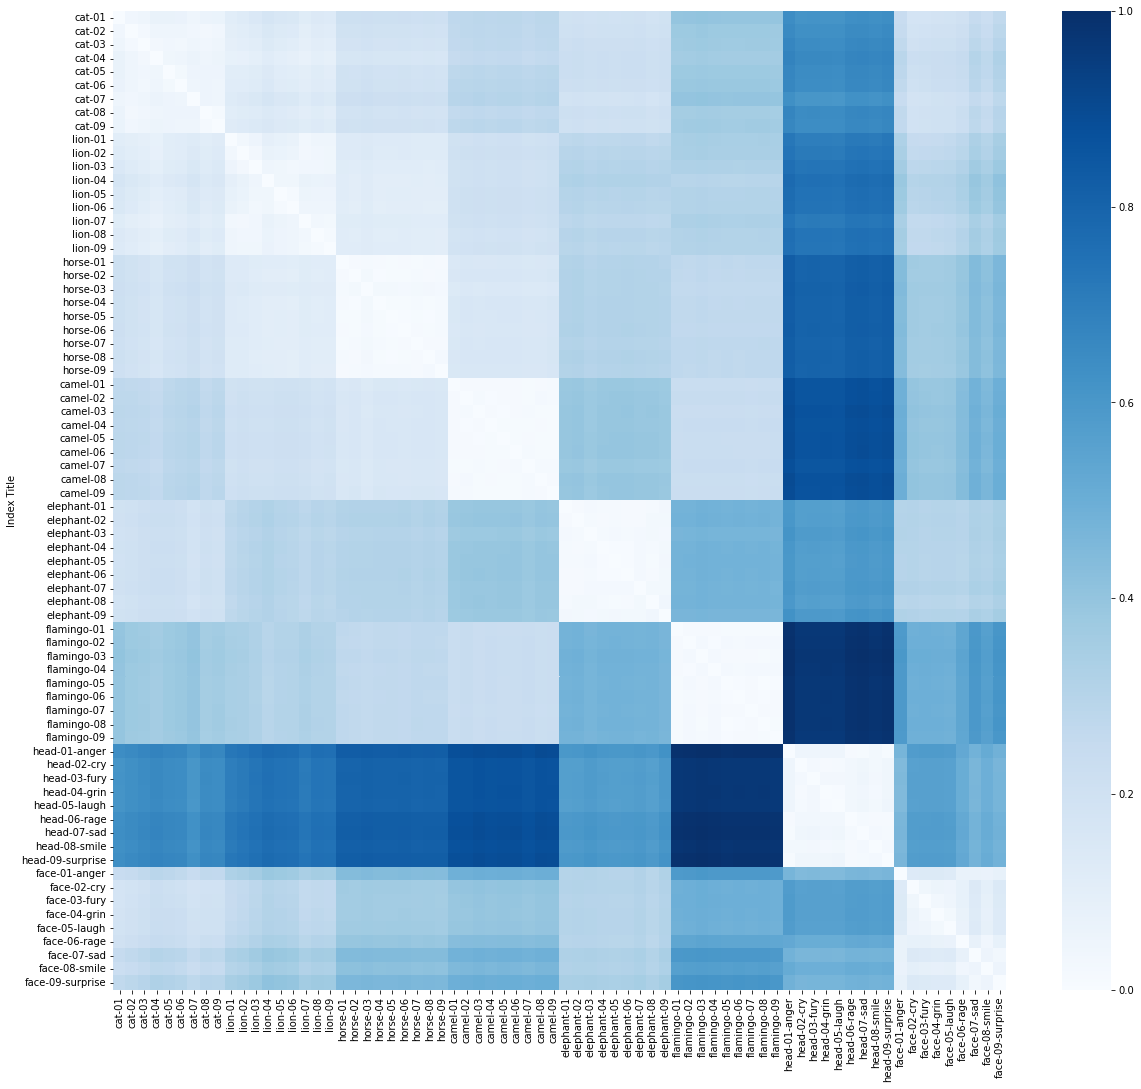

In [43]:
import seaborn as sns
import pandas as pd


labels = [i.split('/', 5)[-1].replace('.obj', '') for i in file_addr]


plt.figure(figsize=(20,18))

df_distance = pd.DataFrame(distance_matrix / np.max(distance_matrix), columns=labels)
df_distance['Index Title'] = labels
df_distance.set_index('Index Title', inplace=True)

sns.heatmap(df_distance, cmap='Blues')

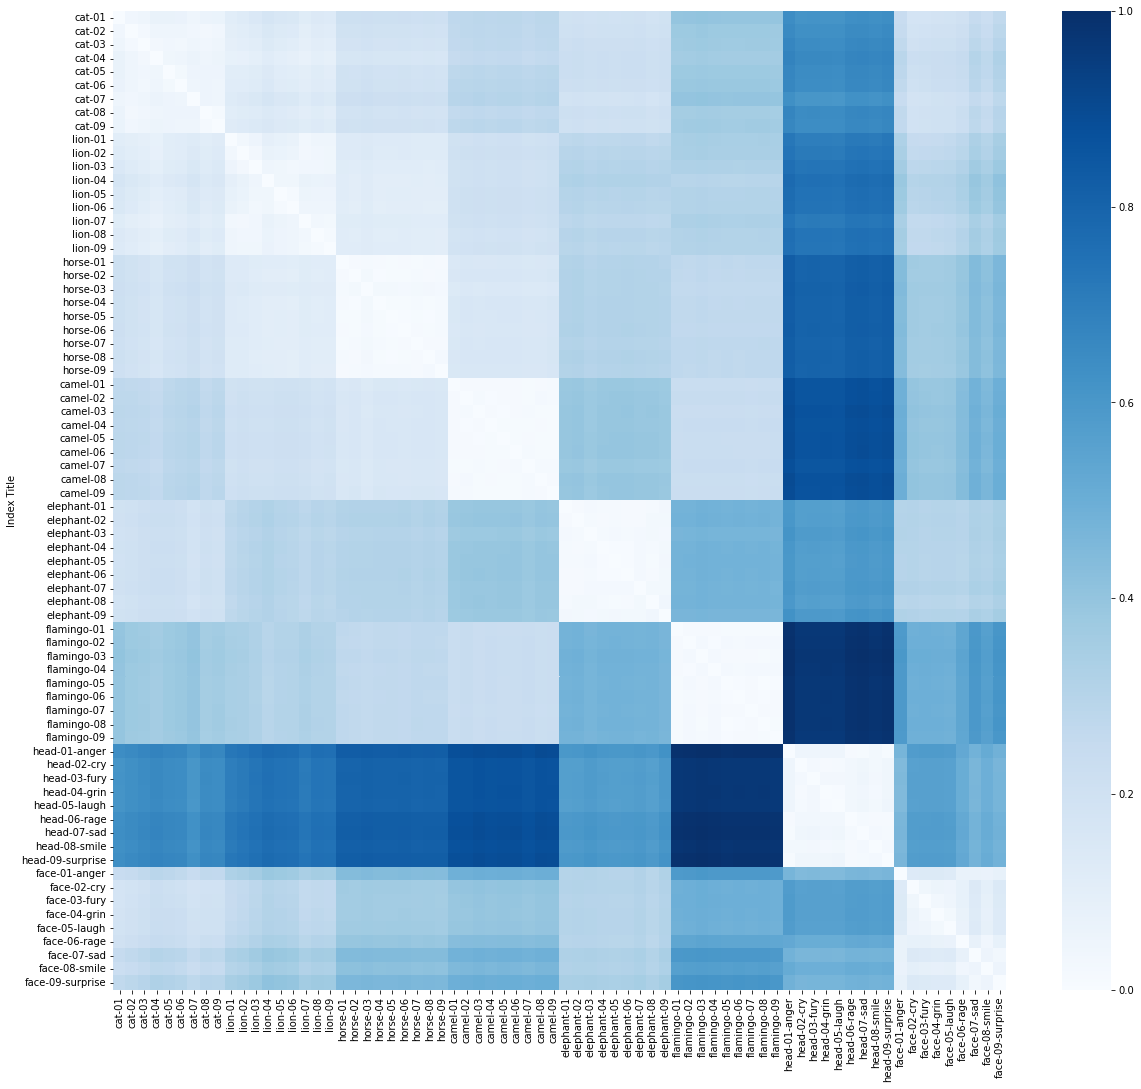

In [44]:
plt.figure(figsize=(20,18))
swarm_plot = sns.heatmap(df_distance, cmap='Blues')
fig = swarm_plot.get_figure()
fig.savefig('drive/My Drive/shape retrieval/output/distance_matrix_Shape_DNA.jpg', dpi=300)

In [45]:
with open('drive/My Drive/shape retrieval/output/distance_matrix_Shape_DNA.npy', 'wb') as f:
  np.save(f, distance_matrix)

In [46]:
with open('drive/My Drive/shape retrieval/output/distance_matrix_Shape_DNA.npy', 'rb') as f:
  a = np.load(f)

In [47]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
distance_transform = embedding.fit_transform(distance_matrix / np.max(distance_matrix))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:518: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



In [48]:
colors = ['red', 'orange', 'yellow', 'green', 'lightskyblue', 'blue', 'purple', 'black']
color_map = []

for i in range(8):
  color_map += [colors[i]]*9

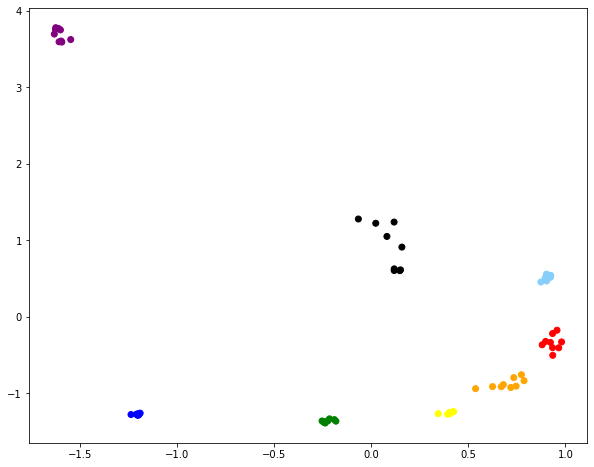

In [49]:
plt.figure(figsize=(10,8))
plt.scatter(distance_transform[:, 0], distance_transform[:, 1], c=color_map)

## Query test
Input: an image
Output: similar images + the computation time

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'lion', 'lion', 'lion', 'lion', 'lion', 'lion', 'lion', 'lion', 'lion', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'camel', 'camel', 'camel', 'camel', 'camel', 'camel', 'camel', 'camel', 'camel', 'elephant', 'elephant', 'elephant', 'elephant', 'elephant', 'elephant', 'elephant', 'elephant', 'elephant', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'head', 'head', 'head', 'head', 'head', 'head', 'head', 'head', 'head', 'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face']
['cat', 'lion', 'horse', 'camel', 'elephant', 'flamingo', 'head', 'face']


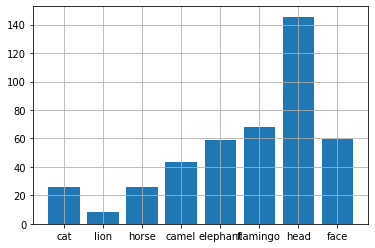

In [61]:
# A test for lion
class_labels = [label.split('-')[0] for label in labels]
print(class_labels)
unique_labels = []
unique_labels.append(class_labels[0])
for i in range(1,len(class_labels)):
  if class_labels[i] != class_labels[i-1]:
    unique_labels.append(class_labels[i])
print(unique_labels)
distance_to_classes = np.zeros(len(unique_labels))
distance_to_class = 0
count_class = 0
for i, spectrum in enumerate(spectrums):
  if class_labels[i] == class_labels[i-1] or i == 0:
    distance_to_class += np.linalg.norm((spectrums[i] - spectrums[10]))
  else:
    distance_to_classes[count_class] = distance_to_class
    count_class += 1
    distance_to_class = 0

distance_to_classes[count_class] = distance_to_class
bar_x_locations = np.arange(len(unique_labels))
plt.bar(bar_x_locations, distance_to_classes, align = 'center')
plt.xticks(bar_x_locations, unique_labels)
plt.grid()
plt.show()
